In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [2]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

In [3]:

"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [4]:
base_path = 'real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)



# image_gen1 = ImageDataGenerator(rescale=1./255.)


train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    color_mode='grayscale',
    class_mode='binary'
)

valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    color_mode='grayscale',
    class_mode='binary'
)


test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

Found 60000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


In [5]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,1)
)
model = build_model(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7031232   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


### Training

In [6]:
train_steps = 60000//64
valid_steps = 12000//64

history = model.fit(
    train_flow,
    epochs = 5,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps 
)

Epoch 1/5
937/937 [==============================] - 15051s 16s/step - loss: 0.5800 - accuracy: 0.6930 - val_loss: 2.2140 - val_accuracy: 0.4864
Epoch 2/5
937/937 [==============================] - 15722s 17s/step - loss: 0.4140 - accuracy: 0.8103 - val_loss: 0.5719 - val_accuracy: 0.7467
Epoch 3/5
937/937 [==============================] - 15250s 16s/step - loss: 0.2777 - accuracy: 0.8834 - val_loss: 0.3191 - val_accuracy: 0.8662
Epoch 4/5
937/937 [==============================] - 14606s 16s/step - loss: 0.1855 - accuracy: 0.9258 - val_loss: 0.3002 - val_accuracy: 0.8774
Epoch 5/5
937/937 [==============================] - 14735s 16s/step - loss: 0.1260 - accuracy: 0.9513 - val_loss: 0.1752 - val_accuracy: 0.9306


In [7]:
model.save('grey_densenet.h5')

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

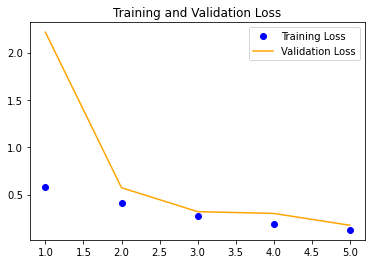

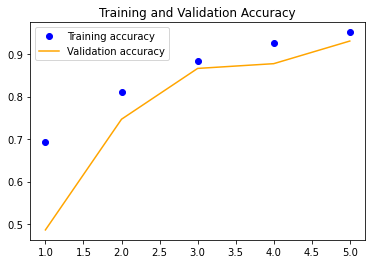

In [9]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [10]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

12000/12000 [==============================] - 1112s 92ms/step


In [11]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.9833113194444444
AP Score: 0.9821520912891872

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6000
           1       0.93      0.95      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000

